# A/B Testing

# Basic Understanding of A/B Testing:

The following figure shows how to use different statistical methods to make A/B testing successful based on the metrics, sample size, and sampling distributions of your data.

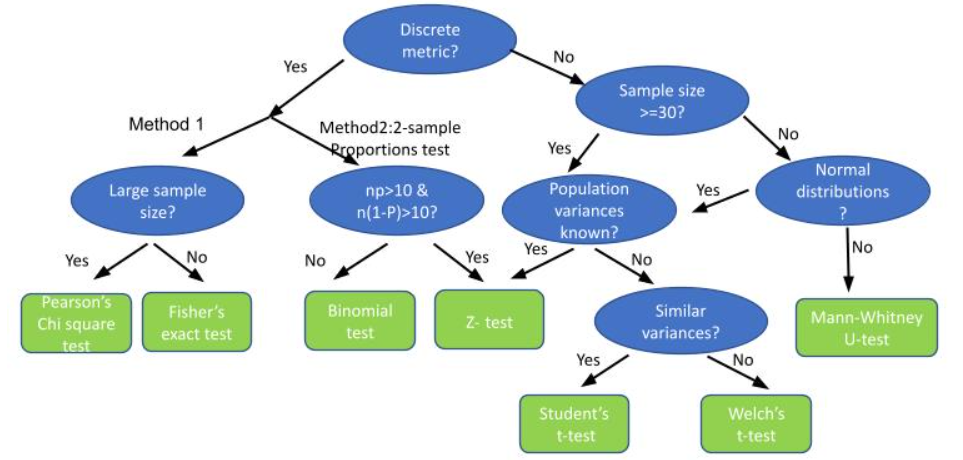

**Discrete metrics VS.continuous metrics**

**1. Discrete metrics**，also called binomial metrics, have only two values 0 and 1, such as **click-through rate, conversion rate, bounce rate.**

**2. continuous metrics**, also called non-binomial metrics, can take continuous values that are not limited to 0 and 1, such as **average revenue, average session duration for a custormer stay on a website, average order value for the custormers.**

**One-tailed test VS. two-tailed test**

The choice of one-tailed test or two-tailed test depends on the original claim in the question. A one-tailed test looks for an “increase” or “decrease” (>,<are used in H1), whereas a two-tailed test looks for a “change”(≠is used in H1). When is a one tailed test appropriate?

The one-tailed test provides more power to detect an effect, but must be very careful about the consequences of missing an effect in the other direction. Imagine you have developed a new drug that you believe is an improvement over an existing drug. You wish to maximize your ability to detect the improvement, so you opt for a one-tailed test. In doing so, you fail to test for the possibility that the new drug is less effective than the existing drug.

If you have considered the consequences of missing an effect in the untested direction, and conclude that they are negligible, You can proceed with a one-tailed test. In scenario two, you produce a new drug, and the cost is much lower than the old one. You are only interested if it is less effective than the old drug. If not, the new drug will be successful. You do not need to care if it is significantly more effective. Then, A one-tailed test would be appropriate for another directional effect is negligible.

When doing A/B testing, there are also several mistakes to be easily made: making a decision too quickly without letting the test run its entire course, or not doing enough retesting, those two might cause Type 1/2 error; and looking at too many metrics instead of focusing on the ones they most care about, which might cause decision confusion. (See mobile games the example: we can do A/B testing on sum_gamerounds, retention_1, retention_7)

1. E-commerce web designer (A/B testing on Discrete metrics: conversion rate)

2. More complex examples

    1. One-Way ANOVA test for one factor and mutiple groups

    2. Post-hoc tests for multiple pairwise comparisons

    3. Two-Way ANOVA test for analyzing the mean responses in an experiment with two factors

3. Mobile Games examples

    1. EDA

    2. Detect and Remove Outerliers

    3. A/B Testing on a continous metric: sum_gamerounds

    4. A/B Testing on discrete metric: retention_1,retention_7

# Solve the Problem

**Problem Statement:**

Let's imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of your user base users.

**Data Used**

The data is from Kaggle(https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv). This data contains the results of an A/B test on what seems to be 2 different designs of a website page (old_page vs. new_page).

In [81]:
# Packages imports
import numpy as np
import pandas as pd
from numpy import percentile
from math import ceil

from scipy.stats import chisquare
from typing import Union

import scipy.stats as stats
from scipy.stats import shapiro

import statsmodels.stats.api as sms
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.graphics.factorplots import interaction_plot

# Some plot styling preferences
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 5
sns.set_style("whitegrid")
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Designing our experiment

#### Formulating a hypothesis


Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a two-tailed test:

**H0: p == p0**

**Ha: p != p0**

where p and p0 stand for the conversion rate of the new and old design, respectively. We'll also set a confidence level of 95%: meaning **alpha = 0.05**

### Choosing the variables

For our test we'll need two groups:

- A control group - They'll be shown the old design
- A treatment (or experimental) group - They'll be shown the new design

This will be our **Independent Variable**. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a ***control*** group we can directly compare their results to the ***treatment*** group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our **Dependent Variable** (i.e. what we are trying to measure), we are interested in capturing the ***conversion rate***. A way we can code this is by each user session with a binary variable:

- 0 - The user did not buy the product during this user session
- 1 - The user bought the product during this user session

This way, we can easily calculate the mean for each group to get the conversion rate of each design.

### Choosing a sample size

Since we won't be using the whole population, the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: **the larger the sample size**, the more precise our estimates (i.e. the smaller our confidence intervals), **the higher the chance to detect a difference in the two groups, if present**. On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

The sample size we need is estimated through something called Power analysis(The **main purpose underlying power analysis is to determine the smallest sample size that is suitable to detect the effect of a given test at the desired level of significance**), and it depends on a few factors:

- **Power of the test (1-β)** - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention
- **Significance Level: Alpha value (α)** - The critical value we set earlier to 0.05
- **Effect size** - How big of a difference we expect there to be between the conversion rates

Since we need a difference of 2%, we can use 13% and 15% to calculate the effect size.

In Python: https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html

By Hand: 

**n = (16*σ²) / 𝛿²**

- n: number of samples.
- σ²: sample variance.
- 𝛿: the difference between the treatment and control groups (in percentage).



***For Understanding:***

Here is the bi-relationship between these three parameters and the required sample size:

- Significance Level decreases → Larger Sample Size
- Statistical Power increases → Larger Sample Size
- The Minimum Detectable Effect decreases → Larger Sample Size


- β = probability of a Type II error, known as a "false negative"
- 1 − β = probability of a "true positive", i.e., correctly rejecting the null hypothesis. "1 − β" is also known as the power of the test.
- α = probability of a Type I error, known as a "false positive"
- 1 − α = probability of a "true negative", i.e., correctly not rejecting the null hypothesis

In [3]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


We'd need **at least 4720 observations for each group**.

Having set the power parameter to 0.8 in practice means that probability of predicting ***true positive*** is 80%. If there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

## 2. Collecting and preparing the data

So now that we have our required sample size, we need to collect the data. Usually at this point we would work with our engineering team to set up the experiment and make sure that you collect enough data based on the sample size needed.

But, we have the data that we got from Kaggle, so we will,

- Read the data
- Clean the data as needed
- Randomly sample 4720 rows for each group


****Note***: Normally, we would not need to perform the last step, this is just for this usecase

In [32]:
df = pd.read_csv('ab_data.csv')
df.shape

(294478, 5)

In [33]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [35]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'],margins=True)

landing_page,new_page,old_page,All
group,,,
control,1928,145274,147202
treatment,145311,1965,147276
All,147239,147239,294478


In [36]:
round(pd.crosstab(df['group'], df['landing_page'],margins=True,normalize=True)*100,3)

landing_page,new_page,old_page,All
group,,,
control,0.655,49.333,49.987
treatment,49.345,0.667,50.013
All,50.000,50.000,100.000


There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :

- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

We'll actually only use the group and converted columns for the analysis.

Before we go ahead and sample the data to get our subset, let's make sure there are no users that have been sampled multiple times.

### Data Cleaning

In [37]:
# Locate rows of duplicate data
dups = df.duplicated()
print(dups.any())

False


In [38]:
# Check duplicate user_id
df[df["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [39]:
df[df.user_id == 698120]

,user_id,timestamp,group,landing_page,converted
988,698120,2017-01-22 07:09:37.540970,control,new_page,0
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0


**SUTVA (Stable Unit Treatment Value Assumption) is violated**, so we need to handle them.

This control group user has been to both old and new landing page, this is bad and we need to handle them.

In [40]:
# Check if there is mismatch between group and landing_page
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mismatch = df_mismatch.shape[0]
print(f"The number of mismatched rows:{n_mismatch} rows" )
print("Percent of mismatched rows:%.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows:3893 rows
Percent of mismatched rows:1.32%


Here are **3893 rows mismatched**, which means that treatment group mismatched with old_page and control group mismatched with new_page.

There are also **3895 duplicated user_id, some of them loading both new page and old page**. Therefore, we need to only keep the right data and drop the mismatched data.

In [41]:
# Extracting the correct data that's needed for the test
df2 = df[(df["group"]=="treatment")&(df["landing_page"]=="new_page")
         |(df["group"]=="control")&(df["landing_page"]=="old_page")]

In [42]:
# Let's drop duplicates if any present
df2.drop_duplicates(subset="user_id",inplace=True)

In [61]:
# Check duplicate user_id
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted


In [62]:
df.shape, df2.shape

((294478, 5), (290584, 5))

In [63]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Sample Ratio Mismatch check

In [69]:
# Fuction to compute the p values for an A/B Test.
def chi_stat_sig(treatment:Union[int,float], control:Union[int,float], alpha:float) -> str:
    """
    Parameters:
    ---------------
    treatement : the count of the unit of randomization in the treatement group (can be a cookie/user id/ device id)
    control : the count of the unit of randomization in the control group (can be a cookie/user id/ device id)
    alpha : the statistical significance boundry
    """
    if not isinstance(alpha,float):
        raise TypeError("variable alpha is not of type float")
        
    control_visitors = control
    treatment_visitors = treatment
    observed_visitors = [treatment_visitors, control_visitors]
    total_visitors = treatment_visitors + control_visitors
    expected_visitors = [total_visitors/2, total_visitors/2]
    
    chi = chisquare(observed_visitors,f_exp=expected_visitors)
    if chi[1] <= alpha:
        return(f'the p-value for the chi squared test is {chi[1]} and there is a difference between treatment group and control group')
    else:
        return(f'the p-value for the chi squared test is {chi[1]} and there is "NO" difference between treatment group and control group')

In [71]:
chi_stat_sig(145310,145274,0.01)

'the p-value for the chi squared test is 0.9467543681597944 and there is "NO" difference between treatment group and control group'

So, there is no Sample Ratio Mismatch issue with the data that's collected

### Sampling

After cleaning the data we are going to sample data. From the top, we understand we need 4720 observations each for both groups.

In [64]:
control_sample = df2[df2['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df2[df2['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [65]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,864622,2017-01-07 19:35:55.115584,control,old_page,0
1,931017,2017-01-20 22:24:11.980654,control,old_page,0
2,822759,2017-01-10 19:00:45.471182,control,old_page,0
3,715765,2017-01-19 23:16:23.269389,control,old_page,0
4,666686,2017-01-23 00:08:30.152180,control,old_page,0
...,...,...,...,...,...
9435,688017,2017-01-12 11:50:30.520706,treatment,new_page,0
9436,699383,2017-01-18 23:14:20.245360,treatment,new_page,0
9437,724124,2017-01-13 18:12:31.235765,treatment,new_page,0
9438,695345,2017-01-13 20:57:14.879484,treatment,new_page,0


In [66]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [67]:
ab_test.group.value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

##### Conversion Rate Understanding

In [72]:
df_counts = pd.DataFrame({"Control_Count": ab_test[ab_test.group=="control"].converted.value_counts(),
"Treatment_Count": ab_test[ab_test.group=="treatment"].converted.value_counts(),
"Control_Ratio": round(ab_test[ab_test.group=="control"].converted.value_counts()/ len(ab_test[ab_test.group=="control"]),4),
"Trement_Ratio": round(ab_test[ab_test.group=="treatment"].converted.value_counts() / len(ab_test[ab_test.group=="treatment"]),4)})

df_counts

,Control_Count,Treatment_Count,Control_Ratio,Trement_Ratio
0,4152,4164,0.8797,0.8822
1,568,556,0.1203,0.1178


In [80]:
conversion_rates = ab_test.groupby('group')['converted'] # Obtain Conversion Rate
std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['Conversion_Rate', 'Std_Deviation', 'Std_Error']


conversion_rates.style.format('{:.4f}')

,Conversion_Rate,Std_Deviation,Std_Error
group,,,
control,0.1203,0.3254,0.0047
treatment,0.1178,0.3224,0.0047


From the above two stats, looks like our two designs performed very similarly, with our old design performing slightly better, approx. 12.03% vs. 11.78% conversion rate.

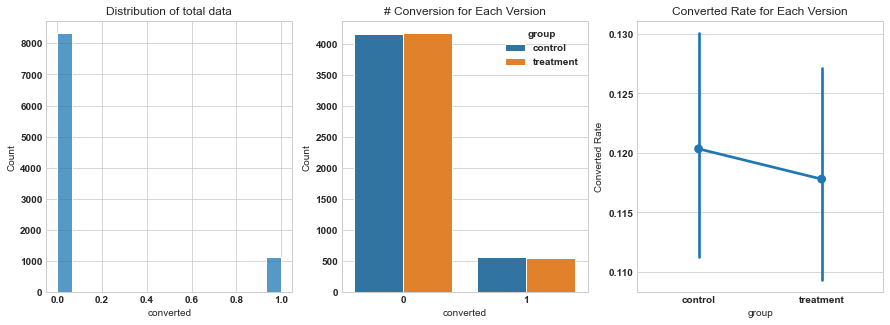

In [79]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

sns.histplot(x="converted", data=ab_test, ax=axes[0])
axes[0].set_title("Distribution of total data")

sns.countplot(x="converted", data=ab_test, hue="group", ax=axes[1])
axes[1].set(title="# Conversion for Each Version", ylabel="Count")

sns.pointplot(x="group", y="converted",kind="point", data=ab_test, ax=axes[2])
# axes[2].set_ylim([0.115, 0.125])
axes[2].set(title="Converted Rate for Each Version",ylabel="Converted Rate")

plt.show()

The conversion rates for our groups are indeed very close. There are some variation in results when sampling from a population.

But, **Is it statistically significant?**

### A/B Test (testing the hypothesis)

In [82]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [86]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.01)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.38
p-value: 0.703
ci 95% for control group: [0.108, 0.133]
ci 95% for treatment group: [0.106, 0.130]


### Conclusion

The p-value is greater than alpha value. So, we fail to reject the Null Hypothesis meaning the new design did not perform significantly different (let alone better) than the old one.

Additionally, if we look at the confidence interval for the treatment group ([0.106, 0.130], i.e. 10.6-13.0%) we notice that:

- It **includes the baseline value of 13%** conversion rate
- It **does not include the target value of 15%** (the 2% uplift that's the new design aiming for did not happen)


Thus, it's more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target that was hoped for. This is further proof that the new design is not likely to be an improvement on the old design, and that means going back to the drawing board!